In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
# Menghitung Makespan
def calculate_makespan(jobs, machines, processing_times):
    makespan = [0] * len(machines)
    for job in jobs:
        processing_times_for_job = processing_times[job]
        for i in range(len(machines)):
            if i == 0:
                makespan[i] += processing_times_for_job[i]
            else:
                makespan[i] = max(makespan[i-1], makespan[i]) + processing_times_for_job[i]
    return max(makespan)

In [4]:
# Order Crossover
def order_crossover(parent1, parent2):
    crossover_points = sorted(random.sample(range(len(parent1)), 2))
    tp1, tp2 = crossover_points[0], crossover_points[1]
    
    child1 = [None] * len(parent1)
    child2 = [None] * len(parent2)
    
    child1[tp1:tp2+1] = parent1[tp1:tp2+1]
    child2[tp1:tp2+1] = parent2[tp1:tp2+1]
    
    index = tp2 + 1
    for gene in parent2[tp2+1:] + parent2[:tp2+1]:
        if gene not in child1:
            child1[index % len(parent1)] = gene
            index += 1
    
    index = tp2 + 1
    for gene in parent1[tp2+1:] + parent1[:tp2+1]:
        if gene not in child2:
            child2[index % len(parent2)] = gene
            index += 1
    
    return child1, child2

In [5]:
# Swap Mutation
def swap_mutation(chromosome):
    mutated_chromosome = chromosome.copy()
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    mutated_chromosome[idx1], mutated_chromosome[idx2] = mutated_chromosome[idx2], mutated_chromosome[idx1]
    return mutated_chromosome

In [6]:
# Roulette Wheel Selection
def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    roulette_wheel = [fitness / total_fitness for fitness in fitness_values]
    selected_chromosome = random.choices(population, weights=roulette_wheel, k=1)[0]
    return selected_chromosome

In [20]:
# Roulette Wheel for New Population
def roulette_wheel_new_selection(population, fitness_values, population_size):
    total_fitness = sum(fitness_values)
    roulette_wheel = [fitness / total_fitness for fitness in fitness_values]
    selected_chromosome = random.choices(population, weights=roulette_wheel, k=population_size)
    return selected_chromosome

In [7]:
# Elitism Selection
def elitism_selection(population, num_elites):
    elites = sorted(population, key=lambda chromosome: calculate_makespan(chromosome, machines, processing_times))
    elites = elites[:num_elites]
    return elites

In [8]:
# Inisiasi populasi awal
def create_initial_population(jobs, population_size, from_excel=False, excel_file=None, sheet_name=None):
    if from_excel:
        data_frame = pd.read_excel(excel_file, sheet_name=sheet_name)
        population = data_frame.iloc[:, 1].values.tolist()
    else:
        population = []
        for _ in range(population_size):
            chromosome = random.sample(jobs, len(jobs))
            population.append(chromosome)
    return population

In [12]:
# Algoritma genetika menggunakan Elitism Selection pada pembentukan populasi baru
def genetic_algorithm1(jobs, machines, processing_times, population_size, num_epochs, crossover_prob, mutation_prob,
                      from_excel=False, excel_file=None, sheet_name=None):
    population = create_initial_population(jobs, population_size, from_excel=from_excel, excel_file=excel_file, sheet_name=sheet_name)
    best_fitness_values = []
    best_chromosomes = []
    best_makespan_values = []
    table_data = []

    crossover_population_size = int(crossover_prob * population_size)
    mutation_population_size = int(mutation_prob * population_size)

    for epoch in range(num_epochs):
        fitness_values = []
        makespan_values = []

        for chromosome in population:
            makespan = calculate_makespan(chromosome, machines, processing_times)
            fitness = 1 / makespan
            fitness_values.append(fitness)
            makespan_values.append(makespan)

        best_fitness = max(fitness_values)
        best_makespan = min(makespan_values)
        best_chromosome = population[makespan_values.index(best_makespan)]

        best_fitness_values.append(best_fitness)
        best_chromosomes.append(best_chromosome)
        best_makespan_values.append(best_makespan)

        table_data.append([epoch + 1, best_chromosome, best_makespan, best_fitness])

        selected_population = []

        # Crossover
        crossover_population = []
        for _ in range(crossover_population_size):
            selected_chromosome = roulette_wheel_selection(population, fitness_values)
            crossover_population.append(selected_chromosome)

        for parent1, parent2 in zip(crossover_population[::2], crossover_population[1::2]):
            child1, child2 = order_crossover(parent1, parent2)
            selected_population.append(child1)
            selected_population.append(child2)

        # Mutasi
        mutation_population = []
        for _ in range(mutation_population_size):
            selected_chromosome = roulette_wheel_selection(population, fitness_values)
            mutation_population.append(selected_chromosome)

        for chromosome in mutation_population:
            mutated_chromosome = swap_mutation(chromosome)
            selected_population.append(mutated_chromosome)

        # Menggabungkan populasi awal dengan hasil crossover dan hasil mutasi
        selected_population += population

        # Seleksi menggunakan elitism untuk menghasilkan populasi baru
        elites = elitism_selection(selected_population, population_size)
        population = elites

    columns = ['Epoch', 'Best Chromosome', 'Makespan', 'Fitness']
    df = pd.DataFrame(table_data, columns=columns)

    plt.plot(best_makespan_values)
    plt.xlabel('Epoch')
    plt.ylabel('Makespan')
    plt.title('Best Makespan Value over Epochs')
    plt.show()

    return best_chromosomes[-1], best_makespan_values[-1], best_fitness_values[-1], df

In [18]:
# Algoritma genetika menggunakan Roulette Wheel Selection pada pembentukan populasi baru
def genetic_algorithm2(jobs, machines, processing_times, population_size, num_epochs, crossover_prob, mutation_prob,
                      from_excel=False, excel_file=None, sheet_name=None):
    population = create_initial_population(jobs, population_size, from_excel=from_excel, excel_file=excel_file, sheet_name=sheet_name)
    best_fitness_values = []
    best_chromosomes = []
    best_makespan_values = []
    table_data = []

    crossover_population_size = int(crossover_prob * population_size)
    mutation_population_size = int(mutation_prob * population_size)

    for epoch in range(num_epochs):
        fitness_values = []
        makespan_values = []

        for chromosome in population:
            makespan = calculate_makespan(chromosome, machines, processing_times)
            fitness = 1 / makespan
            fitness_values.append(fitness)
            makespan_values.append(makespan)

        best_fitness = max(fitness_values)
        best_makespan = min(makespan_values)
        best_chromosome = population[makespan_values.index(best_makespan)]

        best_fitness_values.append(best_fitness)
        best_chromosomes.append(best_chromosome)
        best_makespan_values.append(best_makespan)

        table_data.append([epoch + 1, best_chromosome, best_makespan, best_fitness])

        selected_population = []

        # Perform crossover
        crossover_population = []
        for _ in range(crossover_population_size):
            selected_chromosome = roulette_wheel_selection(population, fitness_values)
            crossover_population.append(selected_chromosome)

        for parent1, parent2 in zip(crossover_population[::2], crossover_population[1::2]):
            child1, child2 = order_crossover(parent1, parent2)
            selected_population.append(child1)
            selected_population.append(child2)

        # Perform mutation
        mutation_population = []
        for _ in range(mutation_population_size):
            selected_chromosome = roulette_wheel_selection(population, fitness_values)
            mutation_population.append(selected_chromosome)

        for chromosome in mutation_population:
            mutated_chromosome = swap_mutation(chromosome)
            selected_population.append(mutated_chromosome)

        # Combine initial population, crossover, and mutation
        selected_population += population
        
        # Perform roulette wheel selection for new population
        fitness_values = []
        makespan_values = []

        for chromosome in selected_population:
            makespan = calculate_makespan(chromosome, machines, processing_times)
            fitness = 1 / makespan
            fitness_values.append(fitness)
            makespan_values.append(makespan)
            
        population = roulette_wheel_new_selection(selected_population, fitness_values, population_size)

    columns = ['Epoch', 'Best Chromosome', 'Makespan', 'Fitness']
    df = pd.DataFrame(table_data, columns=columns)

    plt.plot(best_makespan_values)
    plt.xlabel('Epoch')
    plt.ylabel('Makespan')
    plt.title('Best Makespan Value over Epochs')
    plt.show()

    return best_chromosomes[-1], best_makespan_values[-1], best_fitness_values[-1], df

In [11]:
 # Contoh data input
jobs = ['A','B','C','D','E','F','G','H']
machines = ['M1', 'M2', 'M3']
processing_times = {
    'A': [48, 70, 18],
    'B': [26, 56, 104],
    'C': [44, 6, 22],
    'D': [2, 74, 36],
    'E': [30, 62, 100],
    'F': [40, 96, 10],
    'G': [14, 52, 82],
    'H': [66, 78, 34]
}

# Menjalankan algoritma genetika
population_size = 50
num_epochs = 100
crossover_prob = 0.2
mutation_prob = 0.1
from_excel = True
excel_file = 'first_population.xlsx'
sheet_name = 'Sheet1'

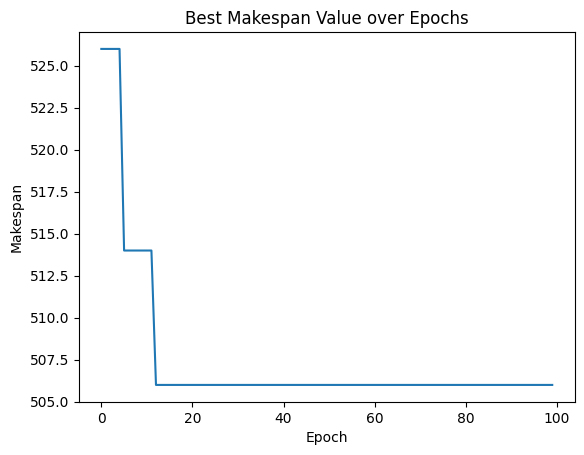

Best Chromosomes:
['D', 'B', 'E', 'H', 'C', 'G', 'A', 'F']
['D', 'G', 'B', 'C', 'E', 'H', 'A', 'F']
['D', 'B', 'C', 'H', 'E', 'G', 'A', 'F']
['D', 'G', 'B', 'C', 'E', 'A', 'H', 'F']
['D', 'B', 'C', 'A', 'E', 'G', 'H', 'F']
['D', 'C', 'B', 'H', 'E', 'G', 'A', 'F']
['D', 'G', 'B', 'H', 'E', 'C', 'A', 'F']
['D', 'B', 'E', 'G', 'C', 'H', 'A', 'F']
['D', 'B', 'E', 'H', 'G', 'C', 'A', 'F']
['D', 'B', 'E', 'G', 'H', 'C', 'A', 'F']
['D', 'B', 'H', 'E', 'C', 'G', 'A', 'F']
['D', 'G', 'E', 'B', 'H', 'C', 'A', 'F']
['D', 'B', 'A', 'C', 'E', 'G', 'H', 'F']
['D', 'B', 'E', 'G', 'C', 'A', 'H', 'F']
['D', 'B', 'C', 'H', 'E', 'A', 'G', 'F']
['D', 'C', 'G', 'H', 'E', 'B', 'A', 'F']
['D', 'B', 'H', 'C', 'E', 'G', 'A', 'F']
['D', 'B', 'C', 'E', 'H', 'G', 'A', 'F']
['D', 'B', 'E', 'A', 'C', 'G', 'H', 'F']
['D', 'C', 'E', 'B', 'H', 'G', 'A', 'F']
['D', 'C', 'B', 'E', 'H', 'G', 'A', 'F']
['D', 'B', 'G', 'H', 'E', 'C', 'A', 'F']
['D', 'B', 'E', 'C', 'H', 'A', 'G', 'F']
['D', 'B', 'C', 'E', 'A', 'G', 'H', 'F'

In [25]:
# Elitsm selection algen
start_time = time.time()
best_chromosome, best_makespan, best_fitness, df = genetic_algorithm1(jobs, machines, processing_times, population_size,
                                                                     num_epochs, crossover_prob, mutation_prob,
                                                                     excel_file=excel_file, sheet_name=sheet_name)
end_time = time.time()

execution_time = end_time - start_time

min_makespan = df['Makespan'].min()
best_chromosomes = df[df['Makespan'] == min_makespan]['Best Chromosome']

print("Best Chromosomes:")
printed_chromosomes = set()
for chromosome in best_chromosomes:
    chromosome_tuple = tuple(chromosome)
    if chromosome_tuple not in printed_chromosomes:
        print(chromosome)
        printed_chromosomes.add(chromosome_tuple)

print("Execution Time:", execution_time, "seconds")
print("Best Makespan:", min_makespan)
print("Best Fitness:", df['Fitness'].max())
print(df)

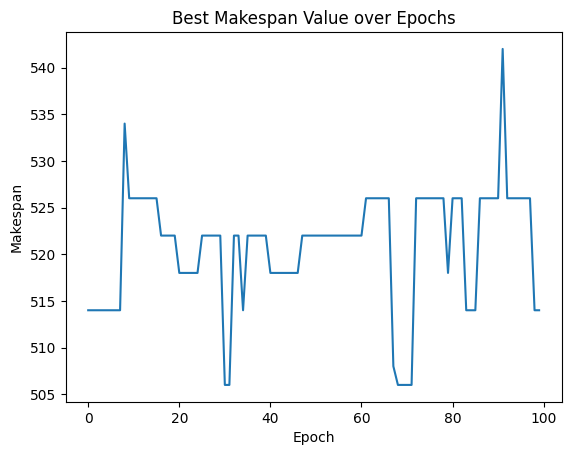

Best Chromosomes:
['D', 'G', 'E', 'H', 'B', 'A', 'C', 'F']
['D', 'B', 'E', 'A', 'G', 'C', 'H', 'F']
Execution Time: 0.4323768615722656 seconds
Best Makespan: 506
Best Fitness: 0.001976284584980237
    Epoch           Best Chromosome  Makespan   Fitness
0       1  [D, E, B, G, H, C, F, A]       514  0.001946
1       2  [D, E, B, G, H, C, F, A]       514  0.001946
2       3  [D, E, B, G, H, C, F, A]       514  0.001946
3       4  [D, E, B, G, H, C, F, A]       514  0.001946
4       5  [D, E, B, G, H, C, F, A]       514  0.001946
..    ...                       ...       ...       ...
95     96  [D, E, C, H, B, F, G, A]       526  0.001901
96     97  [D, E, C, H, B, F, G, A]       526  0.001901
97     98  [D, E, C, H, B, F, G, A]       526  0.001901
98     99  [D, G, E, H, B, F, C, A]       514  0.001946
99    100  [D, G, E, H, B, F, C, A]       514  0.001946

[100 rows x 4 columns]


In [31]:
# Roulette wheel selection Algen
start_time = time.time()
best_chromosome, best_makespan, best_fitness, df = genetic_algorithm2(jobs, machines, processing_times, population_size,
                                                                     num_epochs, crossover_prob, mutation_prob,
                                                                     excel_file=excel_file, sheet_name=sheet_name)
end_time = time.time()

execution_time = end_time - start_time

min_makespan = df['Makespan'].min()
best_chromosomes = df[df['Makespan'] == min_makespan]['Best Chromosome']

print("Best Chromosomes:")
printed_chromosomes = set()
for chromosome in best_chromosomes:
    chromosome_tuple = tuple(chromosome)
    if chromosome_tuple not in printed_chromosomes:
        print(chromosome)
        printed_chromosomes.add(chromosome_tuple)

print("Execution Time:", execution_time, "seconds")
print("Best Makespan:", min_makespan)
print("Best Fitness:", df['Fitness'].max())
print(df)